## Strategy confidence effect on RTs

To do: 

1) Compute the relevant reaction time data 

2) Join the AV columns from the model outputs. 

3) Select only the stay trials.

4) Plot the association between RT and AV.

### Read the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sys
sys.path.append('..')
from paths import Paths
from bandits_helper_functions import*

In [7]:
paths = Paths()
fig_save_path = paths.fig_save_path + 'Confidence&RT/'
KA_FSS_01 = pd.read_csv(paths.model_outputs + 'KA_FSS_01.csv')
PO_FSS_01 = pd.read_csv(paths.model_outputs + 'PO_FSS_01.csv')
behav = pd.read_excel(paths.data + 'behavioural_data.xlsx', converters={'session': str})

## 1. Compute RTs

In [5]:
behav['RT'] = behav['target_touch_time'] - behav['lever_validation_time']
#behav

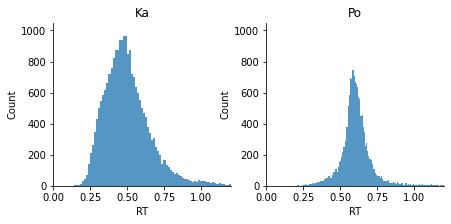

In [6]:
fig, ax = plt.subplots(1, 2, facecolor = 'white', figsize = (7, 3))

sns_plot = sns.histplot(ax = ax[0], data = behav.loc[behav['monkey'] == 'ka'], x = 'RT', stat = 'count');
sns_plot.set_title('Ka')
sns_plot.set_xlim(0, 1.2)
sns_plot.set_ylim(0, 1050)

sns_plot = sns.histplot(ax = ax[1], data = behav.loc[behav['monkey'] == 'po'], x = 'RT', stat = 'count');
sns_plot.set_title('Po')
sns_plot.set_xlim(0, 1.2)
sns_plot.set_ylim(0, 1050)

sns.despine()

In [7]:
fig.savefig(fig_save_path + 'RT_disributions.png', dpi = 300, bbox_inches='tight');

## 2) Join the AV columns from the model outputs.

In [8]:
#behav.set_index(['monkey', 'session', 'trial_id'], inplace=True)
#behav

In [9]:
full_data = pd.merge(behav, KA_FSS_01[['monkey', 'session', 'trial_id', 'action_value']], how="outer", on= ['monkey', 'session', 'trial_id'])

full_data.set_index(['monkey', 'session', 'trial_id'], inplace=True)

PO_FSS_01 = PO_FSS_01[['monkey', 'session', 'trial_id', 'action_value']]
PO_FSS_01.set_index(['monkey', 'session', 'trial_id'], inplace=True)
full_data = full_data.combine_first(PO_FSS_01)
full_data.reset_index(inplace=True)

In [10]:
## Sanity chack - it confirms that AVs missing only when no target was selected and 
## during the first 8 trials of the session. 
## full_data.loc[(full_data['action_value'].isnull()) & full_data['target'].notnull()]

## 3) Select only the stay trials.

In [11]:
full_data = get_shift_stay_variables(full_data)

In [12]:
full_data_filtered = full_data.loc[(full_data['stay'] == 1) & 
                                   (full_data['action_value'].notnull())]


In [13]:
KA_subset = full_data_filtered.loc[full_data_filtered['monkey'] == 'ka']
PO_subset = full_data_filtered.loc[full_data_filtered['monkey'] == 'po']

In [14]:
def cutoff_above_3std(data, verbose = False):
    
    '''
    This function cuts of the mean +3std RT-s. 
    '''
    
    mean = data['RT'].mean()
    std = data['RT'].std()
    nr_points_dropped = data_cutoff = data.loc[data['RT'] > mean + std*3].shape[0]
    data_cutoff = data.loc[data['RT'] < mean + std*3]
    
    print (nr_points_dropped)
    if verbose == True:
        print (data.monkey.unique()[0], 'mean:, {:.3f}, std:, {:.3f}'.format(mean, std))
    
    return data_cutoff


In [15]:
KA_subset_cutoff = cutoff_above_3std(KA_subset, verbose = True)
PO_subset_cutoff = cutoff_above_3std(PO_subset, verbose = True)

166
ka mean:, 0.542, std:, 0.451
153
po mean:, 0.657, std:, 0.487


## 4) Plot

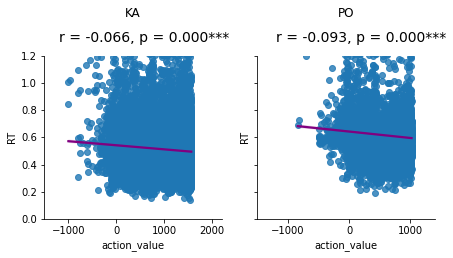

In [16]:
fig, ax = plt.subplots(1, 2, facecolor = 'white', figsize = (7, 3), sharey = True)
sns.despine()


KA_correlation = scipy.stats.pearsonr(KA_subset_cutoff.action_value, KA_subset_cutoff.RT)


sns_plot = sns.regplot(ax = ax[0], data = KA_subset_cutoff, 
                       x = 'action_value', y = 'RT', line_kws={"color": "purple"})
sns_plot.set_title('KA', y = 1.2)
sns_plot.text(-1200, 1.3, 'r = {:.3f}, p = {:.3f}***'.format(KA_correlation.statistic, KA_correlation.pvalue), 
              fontsize = 14)
sns_plot.set_ylim(0, 1.2)
sns_plot.set_xlim(-1500, 2200)




PO_correlation = scipy.stats.pearsonr(PO_subset_cutoff.action_value, PO_subset_cutoff.RT)


sns_plot = sns.regplot(ax = ax[1], data = PO_subset_cutoff, 
                       x = 'action_value', y = 'RT', line_kws={"color": "purple"})
sns_plot.set_title('PO', y = 1.2)
sns_plot.text(-1200, 1.3, 'r = {:.3f}, p = {:.3f}***'.format(PO_correlation.statistic, PO_correlation.pvalue), 
              fontsize = 14)
sns_plot.set_ylim(0, 1.2)
sns_plot.set_xlim(-1500, 1400);

In [17]:
fig.savefig(fig_save_path + 'confidence_vs_rt_wcutoff.png', dpi = 300, bbox_inches='tight');

## 5) RT selection by target

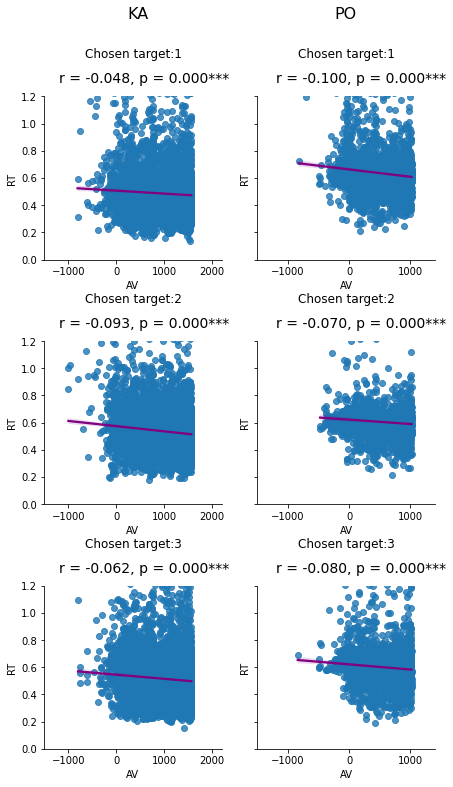

In [60]:
fig, ax = plt.subplots(3, 2, facecolor = 'white', figsize = (7, 12), sharey = True)
sns.despine()



for i in range(3):
    
    ## KA - CORRELATION
    KA_correlation = scipy.stats.pearsonr(KA_subset_cutoff.loc[KA_subset_cutoff['target'] == i+1].action_value, 
                                          KA_subset_cutoff.loc[KA_subset_cutoff['target'] == i+1].RT)
    ## KA - PLOT
    sns_plot = sns.regplot(ax = ax[i, 0], data = KA_subset_cutoff.loc[KA_subset_cutoff['target'] == i+1], 
                           x = 'action_value', y = 'RT', line_kws={"color": "purple"})

    
    sns_plot.set_title('Chosen target:' + str(i+1), y = 1.2)
    sns_plot.text(-1200, 1.3, 'r = {:.3f}, p = {:.3f}***'.format(KA_correlation.statistic, KA_correlation.pvalue), 
                  fontsize = 14)
    sns_plot.set_ylim(0, 1.2)
    sns_plot.set_xlim(-1500, 2200)
    sns_plot.set_xlabel('AV')

    
    
    ## PO - CORRELATION
    PO_correlation = scipy.stats.pearsonr(PO_subset_cutoff.loc[PO_subset_cutoff['target'] == i+1].action_value, 
                                          PO_subset_cutoff.loc[PO_subset_cutoff['target'] == i+1].RT)


    ## PO - PLOT
    sns_plot = sns.regplot(ax = ax[i, 1], data = PO_subset_cutoff.loc[PO_subset_cutoff['target'] == i+1], 
                           x = 'action_value', y = 'RT', line_kws={"color": "purple"})
    sns_plot.set_title('Chosen target:' + str(i+1), y = 1.2)
    sns_plot.text(-1200, 1.3, 'r = {:.3f}, p = {:.3f}***'.format(PO_correlation.statistic, PO_correlation.pvalue), 
                  fontsize = 14)
    sns_plot.set_ylim(0, 1.2)
    sns_plot.set_xlim(-1500, 1400)
    sns_plot.set_xlabel('AV')
    

    
plt.subplots_adjust(hspace = 0.5)
fig.text(0.29, .97, 'KA', fontsize = 16)
fig.text(0.7, .97, 'PO', fontsize = 16);

In [61]:
fig.savefig(fig_save_path + 'confidence_vs_rt_wcutoff_by_target.png', dpi = 300, bbox_inches='tight');